# Combining Features and Building Predictive Models

In [ ]:
## this is for my (Eric) Spark setup, you don't need to run this
import findspark
findspark.init()

In [41]:
import os
from pyspark.sql import SparkSession
import pyspark.sql.types as typ
import pyspark.sql.functions as F
from pyspark.sql import DataFrame
from functools import reduce
from pyspark.sql.functions import col, asc
from pyspark.sql import SQLContext
from pyspark.sql.types import StructType
from pyspark.sql.types import StructField
from pyspark.sql.types import StringType, DoubleType, DateType
from pyspark.sql import SparkSession
import pandas as pd
import numpy as np
import pyspark.mllib.regression as reg
from pyspark.mllib.classification import LogisticRegressionWithLBFGS
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.mllib.tree import RandomForest, GradientBoostedTrees
from pyspark.ml.stat import Correlation


In [42]:
spark = SparkSession \
    .builder \
    .getOrCreate()

sc = spark.sparkContext

## Import Candidates

In [43]:
df_house = spark.read.csv('df_house.csv', inferSchema=True, header=True)

In [44]:
#clean up some titles
df_house = df_house.withColumnRenamed('candidatevotes', 'CAND_VOTES')
df_house = df_house.withColumnRenamed('totalvotes', 'TOTAL_VOTES')
df_house = df_house.withColumnRenamed('VOTE_percent', 'PERCENT_VOTES')

#drop index that is brought in
df_house = df_house.drop(col('_c0'))

In [45]:
df_house.printSchema()

root
 |-- CAND_ID: string (nullable = true)
 |-- CAND_NAME: string (nullable = true)
 |-- CAND_PTY_AFFILIATION: string (nullable = true)
 |-- CAND_ELECTION_YR: integer (nullable = true)
 |-- CAND_OFFICE_ST: string (nullable = true)
 |-- CAND_OFFICE: string (nullable = true)
 |-- CAND_OFFICE_DISTRICT: double (nullable = true)
 |-- CAND_ICI: string (nullable = true)
 |-- CAND_STATUS: string (nullable = true)
 |-- CAND_PCC: string (nullable = true)
 |-- CAND_CITY: string (nullable = true)
 |-- CAND_ST: string (nullable = true)
 |-- CAND_ZIP: double (nullable = true)
 |-- CAND_VOTES: integer (nullable = true)
 |-- TOTAL_VOTES: integer (nullable = true)
 |-- PERCENT_VOTES: double (nullable = true)
 |-- WINNER: integer (nullable = true)



### Add Incumbent feature column as 1/0

In [46]:
df_house.groupBy('CAND_ICI').count().show()

+--------+-----+
|CAND_ICI|count|
+--------+-----+
|    null|    5|
|       O|  198|
|       C|  655|
|       I|  692|
+--------+-----+



In [47]:
df_house = df_house.withColumn('CAND_ICU', F.when(col('CAND_ICI') == 'I', 1.0).otherwise(0.0))
df_house.groupBy('CAND_ICU').count().show()

+--------+-----+
|CAND_ICU|count|
+--------+-----+
|     0.0|  858|
|     1.0|  692|
+--------+-----+



Split into 2016, 2018 to add in features as they are year dependent

In [48]:
df_house16 = df_house.filter(df_house.CAND_ELECTION_YR == 2016)
df_house18 = df_house.filter(df_house.CAND_ELECTION_YR == 2018)

## Import Features

**2016:**

In [49]:
#reading in features 2016
avgsum_donation_16 = spark.read.csv('./features/avgsum_donation-16.csv', inferSchema=True, header=True)
num_big_donations_16 = spark.read.csv('./features/num_big_donations-16.csv', inferSchema=True, header=True)
num_out_of_state_donations_16 = spark.read.csv('./features/num_out_of_state_donations-16.csv', inferSchema=True, header=True)
numdonations16 = spark.read.csv('./features/numdonations16.csv', inferSchema=True, header=True)

**2018:**

In [50]:
#reading in features 2018
avgsum_donation_18 = spark.read.csv('./features/avgsum_donation-18.csv', inferSchema=True, header=True)
num_big_donations_18 = spark.read.csv('./features/num_big_donations-18.csv', inferSchema=True, header=True)
num_out_of_state_donations_18 = spark.read.csv('./features/num_out_of_state_donations-18.csv', inferSchema=True, header=True)
numdonations18 = spark.read.csv('./features/numdonations18.csv', inferSchema=True, header=True)

**2020:**

In [51]:
#reading in features 2020
avgsum_donation_20 = spark.read.csv('./features/avgsum_donation-20.csv', inferSchema=True, header=True)
num_big_donations_20 = spark.read.csv('./features/num_big_donations-20.csv', inferSchema=True, header=True)
num_out_of_state_donations_20 = spark.read.csv('./features/num_out_of_state_donations-20.csv', inferSchema=True, header=True)
numdonations20 = spark.read.csv('./features/numdonations20.csv', inferSchema=True, header=True)

## Join Candidates to Features

**2016:**

In [52]:
df_house16 = df_house16.join(avgsum_donation_16, on='CAND_ID', how='left')
df_house16 = df_house16.withColumnRenamed('avgdonation','AVERAGE_DONATION')
df_house16 = df_house16.withColumnRenamed('sumdonation','TOTAL_DONATIONS')
df_house16 = df_house16.drop(col('_c0'))

df_house16 = df_house16.join(num_big_donations_16, on='CAND_ID', how='left')
df_house16 = df_house16.withColumnRenamed('numdonat','NUMBER_BIG_DONATIONS')
df_house16 = df_house16.drop(col('_c0'))

df_house16 = df_house16.join(num_out_of_state_donations_16, on='CAND_ID', how='left')
df_house16 = df_house16.withColumnRenamed('numdonat','NUMBER_OUT_OF_STATE_DONATIONS')
df_house16 = df_house16.drop(col('_c0'))

df_house16 = df_house16.join(numdonations16, on='CAND_ID', how='left')
df_house16 = df_house16.withColumnRenamed('numdonat','NUMBER_OF_DONATIONS')
df_house16 = df_house16.drop(col('_c0'))

#identification based on existence, so filling na values with 0 where none found
df_house16 = df_house16.fillna({'NUMBER_BIG_DONATIONS':0, 'NUMBER_OUT_OF_STATE_DONATIONS':0})

#not not all candidates were able to join - filter out those without contribution info
df_house16 = df_house16.filter(col('TOTAL_DONATIONS').isNotNull())

#simpler filters
df_house16 = df_house16.withColumn('CONCAT', F.concat(col('CAND_ELECTION_YR'),F.lit('_'),col('CAND_OFFICE_ST'),F.lit('_'),col('CAND_OFFICE_DISTRICT')))

#identify races that only have information by CONCAT value
single_cand16 = df_house16.groupBy('CAND_ELECTION_YR','CAND_OFFICE_ST','CAND_OFFICE_DISTRICT') \
                          .count() \
                          .filter('count == 1') \
                          .select('CAND_ELECTION_YR','CAND_OFFICE_ST','CAND_OFFICE_DISTRICT') \
                          .withColumn('CONCAT', F.concat(col('CAND_ELECTION_YR'),F.lit('_'),col('CAND_OFFICE_ST'),F.lit('_'),col('CAND_OFFICE_DISTRICT'))) \
                          .select('CONCAT').rdd.flatMap(lambda x: x).collect()

#create list of 
all_cand16 = df_house16.select('CONCAT').rdd.flatMap(lambda x: x).collect()

#identifies from all races only those not single
multi_cand16 = [x for x in all_cand16 if x not in single_cand16]

#filter candidate pool to final form
df_house16 = df_house16.filter(col('CONCAT').isin(multi_cand16))


#calculate totals for various metrics
agg_total_donations16 = df_house16.groupBy('CONCAT').agg({'TOTAL_DONATIONS':'sum'}).withColumnRenamed('sum(TOTAL_DONATIONS)','AGG_TOTAL_DONATIONS')
df_house16 = df_house16.join(agg_total_donations16, on='CONCAT', how='left')

agg_number_big_donations16 = df_house16.groupBy('CONCAT').agg({'NUMBER_BIG_DONATIONS':'sum'}).withColumnRenamed('sum(NUMBER_BIG_DONATIONS)','AGG_NUMBER_BIG_DONATIONS')
df_house16 = df_house16.join(agg_number_big_donations16, on='CONCAT', how='left')

agg_number_out_of_state_donations16 = df_house16.groupBy('CONCAT').agg({'NUMBER_OUT_OF_STATE_DONATIONS':'sum'}).withColumnRenamed('sum(NUMBER_OUT_OF_STATE_DONATIONS)','AGG_NUMBER_OUT_OF_STATE_DONATIONS')
df_house16 = df_house16.join(agg_number_out_of_state_donations16, on='CONCAT', how='left')

agg_number_of_donations16 = df_house16.groupBy('CONCAT').agg({'NUMBER_OF_DONATIONS':'sum'}).withColumnRenamed('sum(NUMBER_OF_DONATIONS)','AGG_NUMBER_OF_DONATIONS')
df_house16 = df_house16.join(agg_number_of_donations16, on='CONCAT', how='left')


#relative calculations between candidates for a given race
df_house16 = df_house16.withColumn('REL_TOTAL_DONATIONS', col('TOTAL_DONATIONS')/col('AGG_TOTAL_DONATIONS'))
df_house16 = df_house16.withColumn('REL_NUMBER_BIG_DONATIONS', col('NUMBER_BIG_DONATIONS')/col('AGG_NUMBER_BIG_DONATIONS'))
df_house16 = df_house16.withColumn('REL_NUMBER_OUT_OF_STATE_DONATIONS', col('NUMBER_OUT_OF_STATE_DONATIONS')/col('AGG_NUMBER_OUT_OF_STATE_DONATIONS'))
df_house16 = df_house16.withColumn('REL_NUMBER_OF_DONATIONS', col('NUMBER_OF_DONATIONS')/col('AGG_NUMBER_OF_DONATIONS'))
df_house16 = df_house16.withColumn('PERCENT_BIG_DONATIONS', col('NUMBER_BIG_DONATIONS')/col('NUMBER_OF_DONATIONS'))
df_house16 = df_house16.withColumn('PERCENT_OUT_OF_STATE_DONATIONS', col('NUMBER_OUT_OF_STATE_DONATIONS')/col('NUMBER_OF_DONATIONS'))


In [13]:
df_house16.count()

502

**2018:**

In [53]:
df_house18 = df_house18.join(avgsum_donation_18, on='CAND_ID', how='left')
df_house18 = df_house18.withColumnRenamed('avgdonation','AVERAGE_DONATION')
df_house18 = df_house18.withColumnRenamed('sumdonation','TOTAL_DONATIONS')
df_house18 = df_house18.drop(col('_c0'))

df_house18 = df_house18.join(num_big_donations_18, on='CAND_ID', how='left')
df_house18 = df_house18.withColumnRenamed('numdonat','NUMBER_BIG_DONATIONS')
df_house18 = df_house18.drop(col('_c0'))

df_house18 = df_house18.join(num_out_of_state_donations_18, on='CAND_ID', how='left')
df_house18 = df_house18.withColumnRenamed('numdonat','NUMBER_OUT_OF_STATE_DONATIONS')
df_house18 = df_house18.drop(col('_c0'))

df_house18 = df_house18.join(numdonations18, on='CAND_ID', how='left')
df_house18 = df_house18.withColumnRenamed('numdonat','NUMBER_OF_DONATIONS')
df_house18 = df_house18.drop(col('_c0'))

#identification based on existence, so filling na values with 0 where none found
df_house18 = df_house18.fillna({'NUMBER_BIG_DONATIONS':0, 'NUMBER_OUT_OF_STATE_DONATIONS':0})

#not not all candidates were able to join - filter out those without contribution info
df_house18 = df_house18.filter(col('TOTAL_DONATIONS').isNotNull())

#simpler filters
df_house18 = df_house18.withColumn('CONCAT', F.concat(col('CAND_ELECTION_YR'),F.lit('_'),col('CAND_OFFICE_ST'),F.lit('_'),col('CAND_OFFICE_DISTRICT')))

###

#identify races that only have information by CONCAT value
single_cand18 = df_house18.groupBy('CAND_ELECTION_YR','CAND_OFFICE_ST','CAND_OFFICE_DISTRICT') \
                          .count() \
                          .filter('count == 1') \
                          .select('CAND_ELECTION_YR','CAND_OFFICE_ST','CAND_OFFICE_DISTRICT') \
                          .withColumn('CONCAT', F.concat(col('CAND_ELECTION_YR'),F.lit('_'),col('CAND_OFFICE_ST'),F.lit('_'),col('CAND_OFFICE_DISTRICT'))) \
                          .select('CONCAT').rdd.flatMap(lambda x: x).collect()

#create list of all candidate races
all_cand18 = df_house18.select('CONCAT').rdd.flatMap(lambda x: x).collect()

#identifies from all races only those not single
multi_cand18 = [x for x in all_cand18 if x not in single_cand18]

#filter candidate pool to final form
df_house18 = df_house18.filter(col('CONCAT').isin(multi_cand18))

###

#calculate totals for various metrics
agg_total_donations18 = df_house18.groupBy('CONCAT').agg({'TOTAL_DONATIONS':'sum'}).withColumnRenamed('sum(TOTAL_DONATIONS)','AGG_TOTAL_DONATIONS')
df_house18 = df_house18.join(agg_total_donations18, on='CONCAT', how='left')

agg_number_big_donations18 = df_house18.groupBy('CONCAT').agg({'NUMBER_BIG_DONATIONS':'sum'}).withColumnRenamed('sum(NUMBER_BIG_DONATIONS)','AGG_NUMBER_BIG_DONATIONS')
df_house18 = df_house18.join(agg_number_big_donations18, on='CONCAT', how='left')

agg_number_out_of_state_donations18 = df_house18.groupBy('CONCAT').agg({'NUMBER_OUT_OF_STATE_DONATIONS':'sum'}).withColumnRenamed('sum(NUMBER_OUT_OF_STATE_DONATIONS)','AGG_NUMBER_OUT_OF_STATE_DONATIONS')
df_house18 = df_house18.join(agg_number_out_of_state_donations18, on='CONCAT', how='left')

agg_number_of_donations18 = df_house18.groupBy('CONCAT').agg({'NUMBER_OF_DONATIONS':'sum'}).withColumnRenamed('sum(NUMBER_OF_DONATIONS)','AGG_NUMBER_OF_DONATIONS')
df_house18 = df_house18.join(agg_number_of_donations18, on='CONCAT', how='left')

#relative calculations between candidates for a given race
df_house18 = df_house18.withColumn('REL_TOTAL_DONATIONS', col('TOTAL_DONATIONS')/col('AGG_TOTAL_DONATIONS'))
df_house18 = df_house18.withColumn('REL_NUMBER_BIG_DONATIONS', col('NUMBER_BIG_DONATIONS')/col('AGG_NUMBER_BIG_DONATIONS'))
df_house18 = df_house18.withColumn('REL_NUMBER_OUT_OF_STATE_DONATIONS', col('NUMBER_OUT_OF_STATE_DONATIONS')/col('AGG_NUMBER_OUT_OF_STATE_DONATIONS'))
df_house18 = df_house18.withColumn('REL_NUMBER_OF_DONATIONS', col('NUMBER_OF_DONATIONS')/col('AGG_NUMBER_OF_DONATIONS'))
df_house18 = df_house18.withColumn('PERCENT_BIG_DONATIONS', col('NUMBER_BIG_DONATIONS')/col('NUMBER_OF_DONATIONS'))
df_house18 = df_house18.withColumn('PERCENT_OUT_OF_STATE_DONATIONS', col('NUMBER_OUT_OF_STATE_DONATIONS')/col('NUMBER_OF_DONATIONS'))


In [15]:
df_house18.count()

678

**Combine 2016 and 2018:**

In [54]:
df_house = reduce(DataFrame.unionAll, [df_house16, df_house18])

In [55]:
df_house.printSchema()

root
 |-- CONCAT: string (nullable = true)
 |-- CAND_ID: string (nullable = true)
 |-- CAND_NAME: string (nullable = true)
 |-- CAND_PTY_AFFILIATION: string (nullable = true)
 |-- CAND_ELECTION_YR: integer (nullable = true)
 |-- CAND_OFFICE_ST: string (nullable = true)
 |-- CAND_OFFICE: string (nullable = true)
 |-- CAND_OFFICE_DISTRICT: double (nullable = true)
 |-- CAND_ICI: string (nullable = true)
 |-- CAND_STATUS: string (nullable = true)
 |-- CAND_PCC: string (nullable = true)
 |-- CAND_CITY: string (nullable = true)
 |-- CAND_ST: string (nullable = true)
 |-- CAND_ZIP: double (nullable = true)
 |-- CAND_VOTES: integer (nullable = true)
 |-- TOTAL_VOTES: integer (nullable = true)
 |-- PERCENT_VOTES: double (nullable = true)
 |-- WINNER: integer (nullable = true)
 |-- CAND_ICU: double (nullable = false)
 |-- AVERAGE_DONATION: double (nullable = true)
 |-- TOTAL_DONATIONS: double (nullable = true)
 |-- NUMBER_BIG_DONATIONS: integer (nullable = false)
 |-- NUMBER_OUT_OF_STATE_DONATI

In [16]:
df_house.count()

1180

## Graphical Data Exploration:

Histogram of Relative Total Donations - overlay incumbent receipts/challenger receipts

In [86]:
incumbent_donations_rel = list(df_house.filter('CAND_ICU == 1.0').select('REL_TOTAL_DONATIONS').rdd.map(lambda row: row[0]).collect())
challenger_donations_rel = list(df_house.filter('CAND_ICU == 0.0').select('REL_TOTAL_DONATIONS').rdd.map(lambda row: row[0]).collect())
all_donations = list(df_house.select('TOTAL_DONATIONS').rdd.map(lambda row: row[0]).collect())

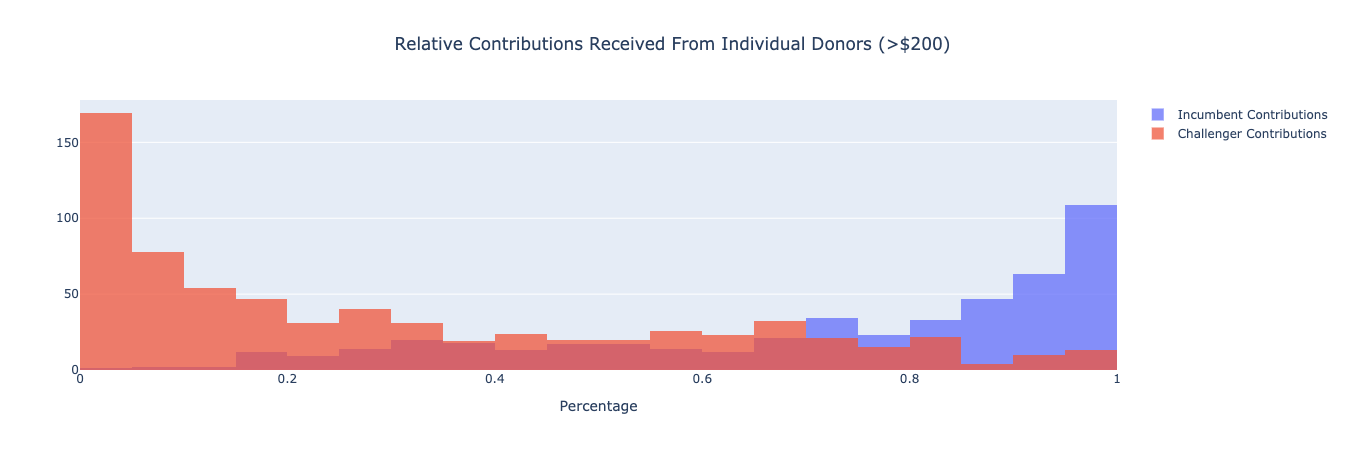

In [89]:
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Histogram(x=incumbent_donations, name='Incumbent Contributions', xbins = dict(start='0')))
fig.add_trace(go.Histogram(x=challenger_donations, name = 'Challenger Contributions', xbins = dict(start='0')))


#xbins = dict(start='0',end='500000',size= 50000)

# Overlay both histograms
fig.update_layout(barmode='overlay', 
                  title_text='Relative Contributions Received From Individual Donors (>$200)', 
                  title_x=0.5,
                  xaxis_title ='Percentage')

# Reduce opacity to see both histograms
fig.update_traces(opacity=0.75)
fig.show()

Box Plot of Total Donations - by incumbent receipts/challenger receipts

In [85]:
incumbent_donations_dol = list(df_house.filter('CAND_ICU == 1.0').select('TOTAL_DONATIONS').rdd.map(lambda row: row[0]).collect())
challenger_donations_dol = list(df_house.filter('CAND_ICU == 0.0').select('TOTAL_DONATIONS').rdd.map(lambda row: row[0]).collect())

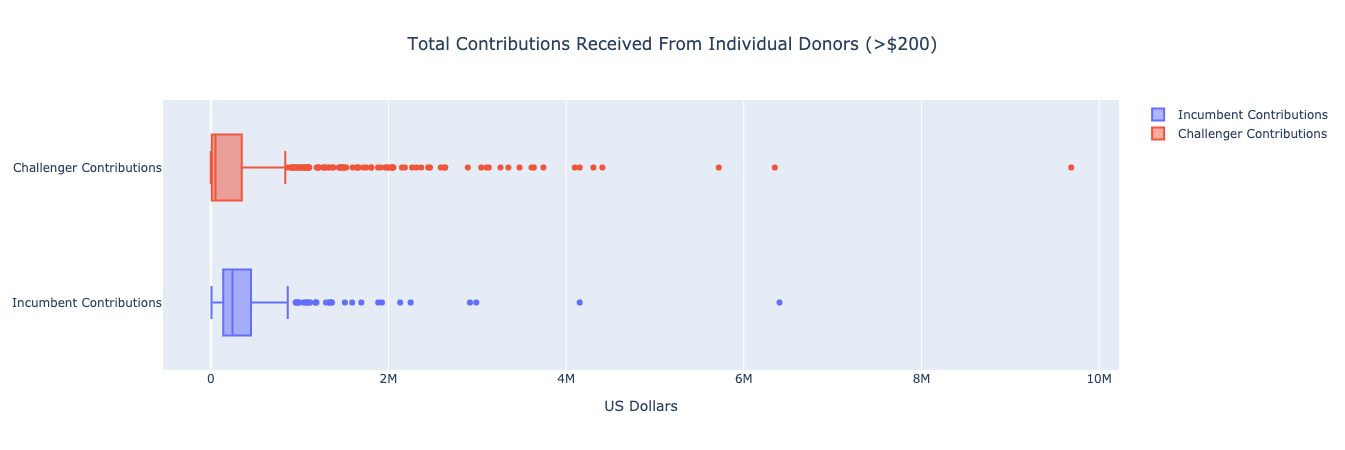

In [90]:
fig = go.Figure()
fig.add_trace(go.Box(x=incumbent_donations_dol, name='Incumbent Contributions'))
fig.add_trace(go.Box(x=challenger_donations_dol, name='Challenger Contributions'))

fig.update_layout(title_text='Total Contributions Received From Individual Donors (>$200)',
                  title_x=0.5,
                  xaxis_title='US Dollars')

fig.show()

Choropleth Map Showing Candidate Counts by State

In [97]:
candidate_locations = df_house.groupBy('CAND_OFFICE_ST').count().toPandas()

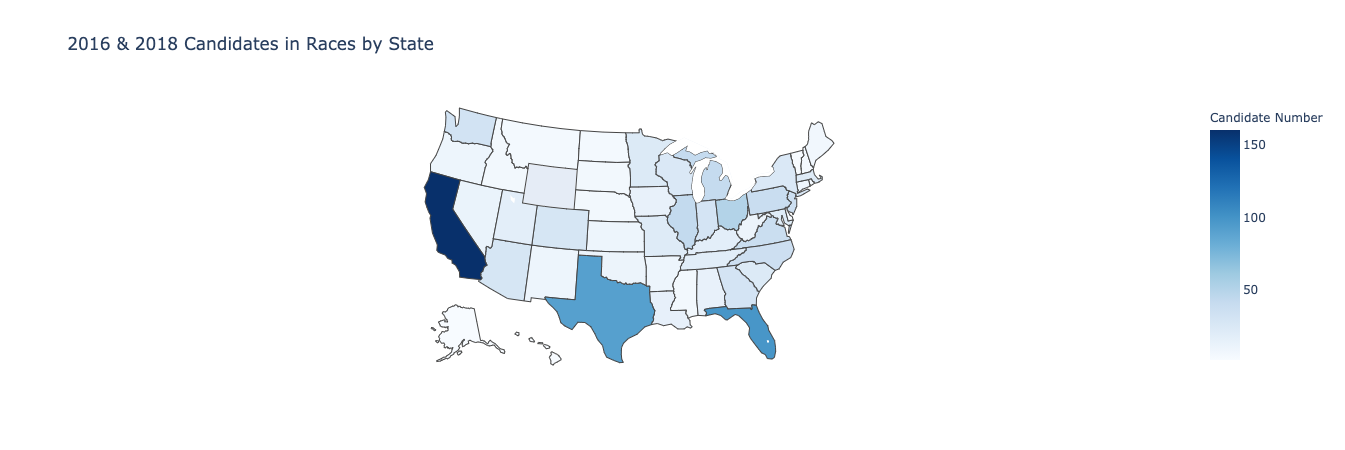

In [102]:
fig = go.Figure(data=go.Choropleth(
    locations=candidate_locations['CAND_OFFICE_ST'], # Spatial coordinates
    z = candidate_locations['count'], # Data to be color-coded
    locationmode = 'USA-states', # set of locations match entries in `locations`
    colorscale = 'Blues',
    colorbar_title = "Candidate Number",
))

fig.update_layout(
    title_text = '2016 & 2018 Candidates in Races by State',
    geo_scope='usa', # limite map scope to USA
)

fig.show()

# Model Preparation:

### General Inputs for CLASSIFICATION Model:  
Defines what variables will be considered and the train/test split

In [16]:
SEED = 1
training_fraction = [0.8, 0.2]
ITERS = 5
target = 'WINNER'
vars_to_keep = ['CAND_ICU','REL_TOTAL_DONATIONS','REL_NUMBER_OF_DONATIONS','PERCENT_BIG_DONATIONS','PERCENT_OUT_OF_STATE_DONATIONS']
df_model = df_house.select([target]+vars_to_keep)

### Check positive/negative balance of data set:  
Relatively balanced, no down/up-sampling required

In [18]:
#relatively balanced data set
df_model.groupBy(target).count().show()

+------+-----+
|WINNER|count|
+------+-----+
|     1|  560|
|     0|  620|
+------+-----+



### Correlation Matrix of the features:
Expect to see decent correlation between incumbent status and the funds raised

In [23]:
# nice to have - not working currently

# r=Correlation.corr(df_model, vars_to_keep)

### Identify **benchmark** classification model by univariate feature selection:  
Create simple models of single variables and look at various metrics to determine what will be the benchmark

In [17]:
def univariate_models(df, target, training_fraction, iters, seed):

    # split the data into train/test using seed
    data_train, data_test = df.randomSplit(training_fraction,seed=seed)
    
    # list of predictor variables
    vars = df.columns[1:]
    
    # results storage
    df_out = pd.DataFrame(index=vars, columns=['accuracy','precision','recall','auroc'])    

    for v in vars:    
        # create train and test dataframes with columns: target, v
        train = data_train.select(target,v)
        test = data_test.select(target,v)

        # cast to LabeledPoint
        # train
        train_lp = train \
                     .rdd \
                     .map(lambda row: reg.LabeledPoint(row[0], row[1:]))
        
        # test
        test_lp = test \
                     .rdd \
                     .map(lambda row: reg.LabeledPoint(row[0], row[1:]))

        # train logistic regression, setting iterations, including intercept
        LR_Model = LogisticRegressionWithLBFGS.train(train_lp, iterations=iters, intercept=True)

        pred_test = test_lp.map(lambda p: (p.label, LR_Model.predict(p.features))) \
                           .map(lambda row: (row[0], row[1] * 1.0))      
                       
        #df_out['weight'].loc[v] = LR_Model.weights  # store the weights

        #accuracy = (tp+tn)/all
        df_out['accuracy'].loc[v] = 1.0 * pred_test.filter(lambda pl: pl[0] == pl[1]).count() / test.count()
        
        tp = pred_test.filter(lambda x: x == (1.0, 1)).count()
        fp = pred_test.filter(lambda x: x == (0.0, 1)).count()
        fn = pred_test.filter(lambda x: x == (1.0, 0)).count()
                
        #precision = tp/(tp+fp); essentially of all predicted positive what % correct
        df_out['precision'].loc[v] = tp/(tp+fp)                                         
       
        #recall = tp/(tp+fn); essentially of all condition positive what % correct
        df_out['recall'].loc[v] = tp/(tp+fn)
        
        # metrics.areaUnderROC
        metrics = BinaryClassificationMetrics(pred_test)
        df_out['auroc'].loc[v] = metrics.areaUnderROC # extract AUROC      
        
    df_out.sort_values(by='accuracy', ascending=False, inplace=True)
    
    return df_out

In [18]:
%time df_output = univariate_models(df_model, target, training_fraction, ITERS, SEED)

CPU times: user 1.14 s, sys: 437 ms, total: 1.58 s
Wall time: 9min 48s


In [19]:
df_output

,accuracy,precision,recall,auroc
CAND_ICU,0.861224,0.931373,0.778689,0.871281
REL_TOTAL_DONATIONS,0.816327,0.793893,0.852459,0.817999
REL_NUMBER_OF_DONATIONS,0.746939,0.734375,0.770492,0.747529
PERCENT_BIG_DONATIONS,0.628571,0.656566,0.532787,0.633077
PERCENT_OUT_OF_STATE_DONATIONS,0.538776,0.569231,0.303279,0.548504


Based on this output, **benchmark** classification model is: **Univariate Logistic Regression Model with REL_TOTAL_DONATIONS** as the input variable.  This model exhibits stable, high performance across the evaluation metrics: 




Rebuild the **benchmark** model to produce the confusion matrix:

In [22]:
##############################
## Classification Benchmark ##
##############################

train, test = df_house.randomSplit(training_fraction,seed=SEED)
    
bench_train = train.select(target,'REL_TOTAL_DONATIONS')
bench_test = test.select(target,'REL_TOTAL_DONATIONS')

bench_train_lp = bench_train \
                .rdd \
                .map(lambda row: reg.LabeledPoint(row[0], row[1:]))
        
bench_test_lp = bench_test \
             .rdd \
             .map(lambda row: reg.LabeledPoint(row[0], row[1:]))

bench_LR_Model = LogisticRegressionWithLBFGS.train(bench_train_lp, iterations=ITERS, intercept=True)
       
bench_pred_test = bench_test_lp.map(lambda p: (p.label, bench_LR_Model.predict(p.features))) \
                               .map(lambda row: (row[0], row[1] * 1.0))

################################
## Benchmark Confusion Matrix ##
################################

tp = bench_pred_test.filter(lambda x: x == (1.0, 1)).count()
tn = bench_pred_test.filter(lambda x: x == (0.0, 0)).count()
fp = bench_pred_test.filter(lambda x: x == (0.0, 1)).count()
fn = bench_pred_test.filter(lambda x: x == (1.0, 0)).count()

confusion_mtx = pd.DataFrame(data = [[tn,fp],[fn,tp]], index = [0,1], columns = [0,1])
confusion_mtx

,0,1
0,105,26
1,24,90


### Identify **champion** classifcation model:

RandomForest Model implementation candidate


In [20]:
############################
## RandomForest Candidate ##
############################

train, test = df_house.randomSplit(training_fraction,seed=SEED)

#including all variables
champ_train = train.select([target]+vars_to_keep)
champ_test = test.select([target]+vars_to_keep)

champ_train_lp = champ_train \
                .rdd \
                .map(lambda row: reg.LabeledPoint(row[0], row[1:]))
        
champ_test_lp = champ_test \
             .rdd \
             .map(lambda row: reg.LabeledPoint(row[0], row[1:]))

champ_RF_Model = RandomForest.trainClassifier(champ_train_lp, numClasses=2, categoricalFeaturesInfo={}, 
                                              numTrees=50, featureSubsetStrategy="auto", 
                                              impurity='gini', maxDepth=3, maxBins=32, seed=SEED)

#significant issues pulling together the labels and estimates - unclear from error readout what the issue was
#created workaround to collect and recreate RDD
predictions = champ_RF_Model.predict(champ_test_lp.map(lambda x: x.features)).collect()
labels = champ_test_lp.map(lambda lp: lp.label).collect()
pred_total = list(zip(labels,predictions))
champ_test = spark.sparkContext.parallelize(pred_total)


######################
## Model Evaluation ##
######################

#accuracy = (tp+tn)/all
df_champ1_accuracy = 1.0 * champ_test.filter(lambda pl: pl[0] == pl[1]).count() / test.count()

tp = champ_test.filter(lambda x: x == (1.0, 1)).count()
fp = champ_test.filter(lambda x: x == (0.0, 1)).count()
fn = champ_test.filter(lambda x: x == (1.0, 0)).count()      
        
#precision = tp/(tp+fp); essentially of all predicted positive what % correct
df_champ1_precision = tp/(tp+fp)                                         
       
#recall = tp/(tp+fn); essentially of all condition positive what % correct
df_champ1_recall = tp/(tp+fn)

#auroc
champ_metrics = BinaryClassificationMetrics(champ_test)
df_champ1_auroc = champ_metrics.areaUnderROC

#place values in data frame for presentation
df_champ1 = pd.DataFrame(columns = ['accuracy','precision','recall','auroc'])
df_champ1.loc[0] = [df_champ1_accuracy,df_champ1_precision,df_champ1_recall,df_champ1_auroc]
df_champ1 = df_champ1.rename(index={0:'RandomForest Model'})
df_champ1


,accuracy,precision,recall,auroc
RandomForest Model,0.918367,0.905172,0.921053,0.917702


In [25]:
#########################
## RF Confusion Matrix ##
#########################

tp = champ_test.filter(lambda x: x == (1.0, 1)).count()
tn = champ_test.filter(lambda x: x == (0.0, 0)).count()
fp = champ_test.filter(lambda x: x == (0.0, 1)).count()
fn = champ_test.filter(lambda x: x == (1.0, 0)).count()

confusion_mtx = pd.DataFrame(data = [[tn,fp],[fn,tp]], index = [0,1], columns = [0,1])
confusion_mtx

,0,1
0,120,11
1,9,105


---
Gradient-Boosted Tree implementation candidate:

In [21]:
##############################
## Gradient Boost Candidate ##
##############################

train, test = df_house.randomSplit(training_fraction,seed=SEED)

#including all variables
champ2_train = train.select([target]+vars_to_keep)
champ2_test = test.select([target]+vars_to_keep)

champ2_train_lp = champ2_train \
                .rdd \
                .map(lambda row: reg.LabeledPoint(row[0], row[1:]))
        
champ2_test_lp = champ2_test \
             .rdd \
             .map(lambda row: reg.LabeledPoint(row[0], row[1:]))

champ_GBT_Model = GradientBoostedTrees.trainClassifier(champ2_train_lp, categoricalFeaturesInfo={}, 
                                                       numIterations=50, learningRate=0.1, 
                                                       maxDepth=3, maxBins=32)

#significant issues pulling together the labels and estimates - unclear from error readout what the issue was
#created workaround to collect and recreate RDD
predictions = champ_GBT_Model.predict(champ2_test_lp.map(lambda x: x.features)).collect()
labels = champ2_test_lp.map(lambda lp: lp.label).collect()
pred_total = list(zip(labels,predictions))
champ2_test = spark.sparkContext.parallelize(pred_total)

######################
## Model Evaluation ##
######################

#accuracy = (tp+tn)/all
df_champ2_accuracy = 1.0 * champ2_test.filter(lambda pl: pl[0] == pl[1]).count() / test.count()

tp = champ2_test.filter(lambda x: x == (1.0, 1)).count()
fp = champ2_test.filter(lambda x: x == (0.0, 1)).count()
fn = champ2_test.filter(lambda x: x == (1.0, 0)).count()      
        
#precision = tp/(tp+fp); essentially of all predicted positive what % correct
df_champ2_precision = tp/(tp+fp)                                         
       
#recall = tp/(tp+fn); essentially of all condition positive what % correct
df_champ2_recall = tp/(tp+fn)

#auroc
champ2_metrics = BinaryClassificationMetrics(champ2_test)
df_champ2_auroc = champ2_metrics.areaUnderROC

#place values in data frame for presentation
df_champ2 = pd.DataFrame(columns = ['accuracy','precision','recall','auroc'])
df_champ2.loc[0] = [df_champ2_accuracy,df_champ2_precision,df_champ2_recall,df_champ2_auroc]
df_champ2 = df_champ2.rename(index={0:'Gradient-Boosted Tree Model'})
df_champ2

,accuracy,precision,recall,auroc
Gradient-Boosted Tree Model,0.885714,0.87069,0.885965,0.884957


In [24]:
##########################
## GBT Confusion Matrix ##
##########################

tp = champ2_test.filter(lambda x: x == (1.0, 1)).count()
tn = champ2_test.filter(lambda x: x == (0.0, 0)).count()
fp = champ2_test.filter(lambda x: x == (0.0, 1)).count()
fn = champ2_test.filter(lambda x: x == (1.0, 0)).count()

confusion_mtx = pd.DataFrame(data = [[tn,fp],[fn,tp]], index = [0,1], columns = [0,1])
confusion_mtx

,0,1
0,116,15
1,13,101


### Results/Conclusions:

Summarize Classification Model Outputs

In [23]:
results_all = pd.concat([df_champ2, df_champ1, df_output])
results_all.sort_values(by='accuracy', ascending=False, inplace=True)
results_all

,accuracy,precision,recall,auroc
RandomForest Model,0.918367,0.905172,0.921053,0.917702
Gradient-Boosted Tree Model,0.885714,0.87069,0.885965,0.884957
CAND_ICU,0.861224,0.931373,0.778689,0.871281
REL_TOTAL_DONATIONS,0.816327,0.793893,0.852459,0.817999
REL_NUMBER_OF_DONATIONS,0.746939,0.734375,0.770492,0.747529
PERCENT_BIG_DONATIONS,0.628571,0.656566,0.532787,0.633077
PERCENT_OUT_OF_STATE_DONATIONS,0.538776,0.569231,0.303279,0.548504
